In [2]:
import geopandas as geopd
import pandas as pd
import hvplot.pandas
import rasterio
#from rasterio.plot import show


import numpy as np

from whitebox.WBT.whitebox_tools import WhiteboxTools


import shapely
from shapely import Point, LineString, MultiLineString
from shapely.ops import split, snap

from graph_utils import *

#from momepy import close_gaps

import os

from tqdm.notebook import tqdm

#import leafmap.leafmap as leafmap

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [3]:
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

src_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/network.gpkg"

dst_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/modified_network.gpkg"

stream_poly_path = "/home/iiro/Documents/DIWA/data/SYKE/vesimuodostumat.gpkg"

dams_path = "/home/iiro/Documents/GIS/Maanmittauslaitoksen data/mml/maastotietokanta/2023/gpkg/MTK-muut_23-03-02.gpkg"

max_seg_length = 500

### TODO 
- clip network with lakes
- clip network with dams
    - each dam becomes a node 
- check network topology
- create new nodes based on the network
- Get the stream length of each network section
- calculate total length to pour and lake path length downstream
- count the amount of dams downstream
    - move the information to the node that is upstream from the network section

- join knowledge of basin id and other useful info to nodes
- Snap the nodes to the raster stream network 
- Calculate subwatersheds
- Vectorize subwatersheds
- 
- Create a simplified network from just the nodes for visualization


In [4]:
def slice_linestrings(base_gdf, cutter_gdf):
    """
    Slices the LineString geometries in base_gdf at the intersection points with the geometries in cutter_gdf.
    
    Parameters:
        base_gdf (geopd.GeoDataFrame): GeoDataFrame containing LineString geometries to be sliced.
        cutter_gdf (geopd.GeoDataFrame): GeoDataFrame containing geometries used for slicing.
    
    Returns:
        geopd.GeoDataFrame: A new GeoDataFrame containing the sliced LineString segments.
    
    Created with chatgpt, then modified from that, prompt:
    Help me create a function in python that slices a geodataframe that has LineString geometry into segments,
    given another geodataframe that has LineString geometry.
    The first geodataframe should be sliced at the intersection points of the two geodataframes

    """
    # If there is nothing to cut, we can return immediatly
    if len(cutter_gdf) == 0:
        return base_gdf

    sliced_segments = []
    
    # Ensure both GeoDataFrames are in the same CRS
    if base_gdf.crs != cutter_gdf.crs:
        cutter_gdf = cutter_gdf.to_crs(base_gdf.crs)

    
    cutter = cutter_gdf['geometry'].union_all()
    for line in base_gdf.geometry:
        #if not isinstance(line, LineString) or not isinstance(line, MultiLineString):
            #raise ValueError("All geometries in base_gdf must be LineStrings.")
    
        splitted = split(line, cutter)
        split_result = list(splitted.geoms)
                
        sliced_segments.extend(split_result)
        
    # Create a GeoSeries from the sliced segments
    sliced = geopd.GeoDataFrame({"geometry":sliced_segments}, geometry="geometry", crs=base_gdf.crs)

    sliced = sliced.drop_duplicates('geometry')
    return sliced

def drop_z_coordinates(line):
    """
    Removes the z-coordinates from a shapely LineString.

    Parameters:
        line (LineString): A shapely LineString with z-coordinates.
    
    Returns:
        LineString: A new LineString with only x and y coordinates.
    """
    if not isinstance(line, LineString):
        raise ValueError("Input must be a shapely LineString.")

    # Extract only x and y coordinates from the LineString
    xy_coords = [(x, y) for x, y, z in line.coords]
    
    # Return a new 2D LineString
    return LineString(xy_coords)

def subdivide_lines(lines, max_seg_length):
    """ Takes in a dataframe and divides it to segments,
    where most of the segments are usually less than the max_seg_length
    Segments at the end of lines can be slightly longer, because is the last point is alone, it is appended to the last segment
    """
    lines['pituus_m'] = lines['geometry'].length
    
    too_big = []
    small_enough = []
    for i, row in lines.iterrows():
        
        if row.pituus_m < max_seg_length:
            small_enough.append(i)
            continue
    
        too_big.append(i)
    
    too_big_sections = lines.loc[too_big, :]
    subdivided_branches = lines.loc[small_enough, :]
    #subdivided_branches = lines.loc[~lines.index.isin(too_big_sections.index)].reset_index(drop=True)
    too_big_sections = too_big_sections.reset_index(drop=True)
    
    
    
    for i, row in too_big_sections.iterrows():
        # changing the row to df so it can be appended later to the subdivided branches
        row_base = geopd.GeoDataFrame(
            dict(zip(list(row.index), list(row.values))),
            crs=too_big_sections.crs, geometry='geometry', index=[0]) 
        line_string = row.geometry
        coords = list(line_string.coords)
        points = [Point(coord) for coord in coords]
        section_points = []
        distance_sum = 0
        segments = []
        # loop iterates trough all but the last point, which is added at the end anyway.
        start_points = points[:-1]
        for j, point in enumerate(start_points):
            distance_sum += shapely.distance(point, points[j + 1])
            section_points.append(point)
            if distance_sum >= max_seg_length:
                segments.append(LineString(section_points))
                # TODO test if this works
                section_points = [point]
                distance_sum = 0
                
    
        section_points.append(points[-1])
        #if len(section_points) > 1: 
        segments.append(LineString(section_points))
        # if the last point is alone, it is appended to the last segment
        #else:
            #segments[-1] = append_to_linestring(segments[-1], section_points[0])
            
        for segment in segments:
            row_base.at[0, 'geometry'] = segment
            subdivided_branches = pd.concat([subdivided_branches, row_base])
    
    # Segment length needs to be  recalculated
    subdivided_branches['pituus_m'] = subdivided_branches['geometry'].length
    subdivided_branches = subdivided_branches.reset_index(drop=True)
    return subdivided_branches

In [9]:
test_selection = 61

tolerance = 0.1

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    if i < test_selection:
        continue
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    
    #boundary = watershed.boundary.explode().reset_index()
    
    bounds = watershed.bounds
    minx = bounds.at[0, 'minx']
    miny = bounds.at[0, 'miny']
    maxx = bounds.at[0, 'maxx']
    maxy = bounds.at[0, 'maxy']
    
    # Getting the gauge that corresponds to the watershed
    place_id = watershed.at[0, 'Paikka_Id']

    # Reading the previously created layers
    orig_pour = geopd.read_file(src_path, layer=f"pour_{place_id}") 
    orig_nodes = geopd.read_file(src_path, layer=f"nodes_{place_id}")
    network = geopd.read_file(src_path, layer=f"network_{place_id}")
    # At least one river (1248) has duplicated geometry, which makes things work wierd
    network = network[network.duplicated("geometry")]
    orig_network = network.copy()
    columns_to_keep = ['objectid', 'geometry']
    network = network[columns_to_keep]
    original_network = network.copy()
    
    stream_poly = geopd.read_file(stream_poly_path, bbox=(minx, miny, maxx, maxy))
    columns_to_keep = ['tyyppi', 'geometry']
    stream_poly = stream_poly[columns_to_keep]
    lakes = stream_poly[stream_poly['tyyppi']=='Allas']
    # Buffering the lakes a bit to remove edge effects (removes some very short vertices)
    
    lakes.loc[:, 'geometry'] = lakes['geometry'].buffer(20)
    lakes = geopd.overlay(lakes, watershed, how='intersection')

    dams = geopd.read_file(dams_path, layer="pato", bbox=(minx, miny, maxx, maxy))
    # Z-coordinate is not needed and may cause weird interactions
    dams['geometry'] = dams.geometry.apply(drop_z_coordinates)
    
    # Multiline geometries are changed into multiple linestrings
    network = network.explode(ignore_index=True)

    # clipping with dams is done before lake division so that hassle of moving attributes can be skipped
    network_dam_is_points = network.overlay(dams, how='intersection', keep_geom_type=False)
    network_dam_is_points = network_dam_is_points.drop_duplicates().reset_index(drop=True)

    network = slice_linestrings(network, dams)
    """
    # Clipping network with  lakes
    intersection = network.overlay(lakes, 'intersection')
    difference = network.overlay(intersection, 'difference')
    
    network = pd.concat([intersection, difference])
    network.loc[:,'tyyppi'] = network['tyyppi'].fillna('Uoma')
    """
    
    # If there are too long vertices, they are subdivided
    network['geometry'] = network['geometry'].segmentize(max_segment_length=max_seg_length/2)

    network = network.explode(ignore_index=True)
    
    # The line subdivision needs some additional attributes to work properly (any column is enough)
    # The function should probably be fixed at some point to wor
    # subdividing the lines
    network = subdivide_lines(network, max_seg_length)

    network['pituus_m'] = network.length

    potential_nodes = get_start_and_end_nodes(network)
    potential_pour = get_pour(potential_nodes, tolerance=tolerance)
    potential_pour = potential_pour.assign(distance=lambda row: row.distance(orig_pour.at[0, 'geometry']))
    potential_pour = potential_pour.loc[potential_pour['distance'] < tolerance]

    # If the tolerance is too large, very small sections near pour point will cause problems
    assert len(potential_pour) != 0, f"Gauge {place_id} is too far from closest pour"
    

    #print(f"Pour {place_id} after boundary clipping {len(pour)}")
    #print("-" * 10)

    # The network is traversed in order to determine the correct pour point and sufficient netowrk coverage
    long_visited = []
    potential_pours = []
    long_nodes = []
    for j, pour_j in potential_pour.iterrows():
        # Changing from 
        pour_j = geopd.GeoDataFrame(
            dict(zip(list(pour_j.index), list(pour_j.values))),
            crs=orig_pour.crs, geometry='geometry', index=[0])
        
        pour_j_connections = add_connections(potential_nodes, pour_j)
        #print(len(pour_j_connections))
        visited = traverse_graph(pour_j_connections, pour_j.at[0, 'id'])
        
        
        # small offshoot branches are skipped, Pesiö's watersheds are special becuse they are so tiny
        pesiö_ids = ['2641', '2643', '2646']
        
        if len(visited) > 2 or place_id in pesiö_ids:
            coverage = round((len(visited) / len(pour_j_connections) *100), 1)
            if coverage < 95:
                print(f"{coverage} % of nodes visited for gauge {place_id}")    
            long_visited.append(visited)
            potential_pours.append(pour_j)
            long_nodes.append(pour_j_connections)
            if len(long_visited) > 1:
                print("multiple pour points remain with long netowrks")
    
    pour = potential_pours[0]

    pour_idx = pour.at[0, 'id']

    
    
    # Getting the nodes that are not on the short side branches
    nodes = long_nodes[0]

    
    #pd.options.mode.chained_assignment = None  # default='warn'
    nodes.loc[:, 'pour'] = nodes.id == pour_idx
    # Setting pour to self loop
    
    nodes['dam'] = nodes['geometry'].intersects(network_dam_is_points.buffer(1).union_all())
    
    # pd.options.mode.chained_assignment = 'warn'  # default='warn'

    
    # Fixing very short sections that arise from dam clipping
    nodes = correct_dam_slivers(nodes, 100)

    
    # Next node type is changed to int, there shouldn't be nan's at this point
    nodes['next'] = nodes['next'].astype(int)
    
    # counting the in-connectedness to differentiate intersections from other types
    nodes = in_connectedness(nodes)

    
    

    #nodes = merge_short_segments(nodes, max_seg_length)

    # Checking that the node topology is intact
    result = check_node_network_topology(nodes)
    
    for key in result:
        if not result[key]:
            print(f"network {watershed.at[0, "Paikka_Id"]} has problems with {key}")
    
    #network.to_file(dst_path, layer=f"network_{place_id}", driver="GPKG")
    
    if i == test_selection:
        break

  0%|          | 0/142 [00:00<?, ?it/s]

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

# TODO
- test the functionality
- make it a function
- make it run until the are no too short sections

In [ ]:

def merge_short_segments(nodes, max_seg_length):
    """
    Merge graph segments that are shorter than a specified maximum length with their neighboring segments.

    Parameters:
    nodes (GeoDataFrame): A GeoDataFrame representing the directed graph structure. Each node must have an 'id' attribute and a 'next' attribute indicating the next node in the graph.
    max_seg_length (float): The maximum allowable segment length. Segments shorter than half of this length will be merged with their neighbors.

    Returns:
    GeoDataFrame: A new GeoDataFrame with the short segments merged into their neighboring segments.

    Notes:
    - The function creates a copy of the input GeoDataFrame to avoid modifying the original data.
    - Removes nodes that are too short downstream and merges their information upstream of the removed node
    - Pour points are not removed
    - Dams (segments with the 'dam' attribute set to True) are not removed during the merging process.
    """
    nodes = nodes.copy()
    
    too_short = nodes[nodes.pituus_m < max_seg_length / 2]
    
    for j, row in too_short.iterrows():
        
        previous_nodes = nodes[nodes['next'] == row.id]
        # Get the smallest length of the previous segment(s)
        previous_l = previous_nodes.pituus_m.min()
    
        # Get the length of the next segment
        next_node = nodes[nodes.id == row.next]
        # min is a useful way to get the value out
        next_l = next_node.pituus_m.min()
    
        # Check if either one of the above is empty, and branch from there
        if previous_l is np.nan:
            has_previous = False
        else:
            has_previous = True
    
        if next_l is np.nan:
            has_following = False
        else:
            has_following = True
    
        
        # Comparing lengths
        if has_previous:
            if has_following:
                # Dams are not removed
                if row.dam:
                    previous_is_shorter = False
                previous_is_shorter = previous_l - next_l
            else:
                previous_is_shorter = True
        else:
            previous_is_shorter = False
    
        # Join happens by deleting the short node and adding it's length to upstream node(s). Skip connections are made
        if previous_is_shorter: 
            if 
            # nodes that lead to the will-be-removed node
            for i, _ in previous_nodes.iterrows():
                nodes.loc[i, 'pituus_m'] = nodes.loc[i, 'pituus_m'] + nodes.at[nodes.at[i, 'next'] , 'pituus_m']
                nodes.loc[i, 'next'] = nodes.loc[nodes.at[i, 'next'] , 'next']
            
            nodes = nodes.drop(j)
        # if the upstream is shorter, If there are multiple upstream nodes, use the minimum length
        # also enter this branch if next node is the pour, because that shall not be deleted
            #the join happens by deleting the short node and adding it's length to upstream node(s)
        
        # the join happens by deleting the downstream node and adding it's length to the current node
        else: 
            """
            There is a chance that already removed node appears again, if a intersection node was deleted. 
            This can be ignored, because the node was updated previously
            """
            if nodes.index.isin(row.next)
            
            if nodes.loc[row.next, 'dam']: # Dams are not removed
                print(f"Node {row.next} is a dam, so it was not removed")
                continue
            updated_nodes = nodes[nodes['next'] == row.next]
            
            for i, _ in updated_nodes.iterrows():
                nodes.at[i, 'pituus_m'] = nodes.at[i, 'pituus_m'] + nodes.at[row.next, 'pituus_m']
                nodes.at[i, 'next'] = nodes.at[nodes.at[i, 'next'] , 'next']
                
            nodes= nodes.drop(row.next)
    return nodes
        
test = merge_short_segments(nodes, max_seg_length)



In [27]:
"""
Simplifying algorithm should:
1. For some reason, dams might get very short sections. Luckily these point to the correct dam node,
    so they just need to merged. Dams are otherwise not simplified.
2. Create skips for nodes with downstream length of < 250 meters,
    if the skip would not create a new length of more than 600 m
2. The length should also be updated
3. Think trough that intersections don't cause problems. 
"""



(380166.0, 445154.0, 7035194.0, 7110346.0)

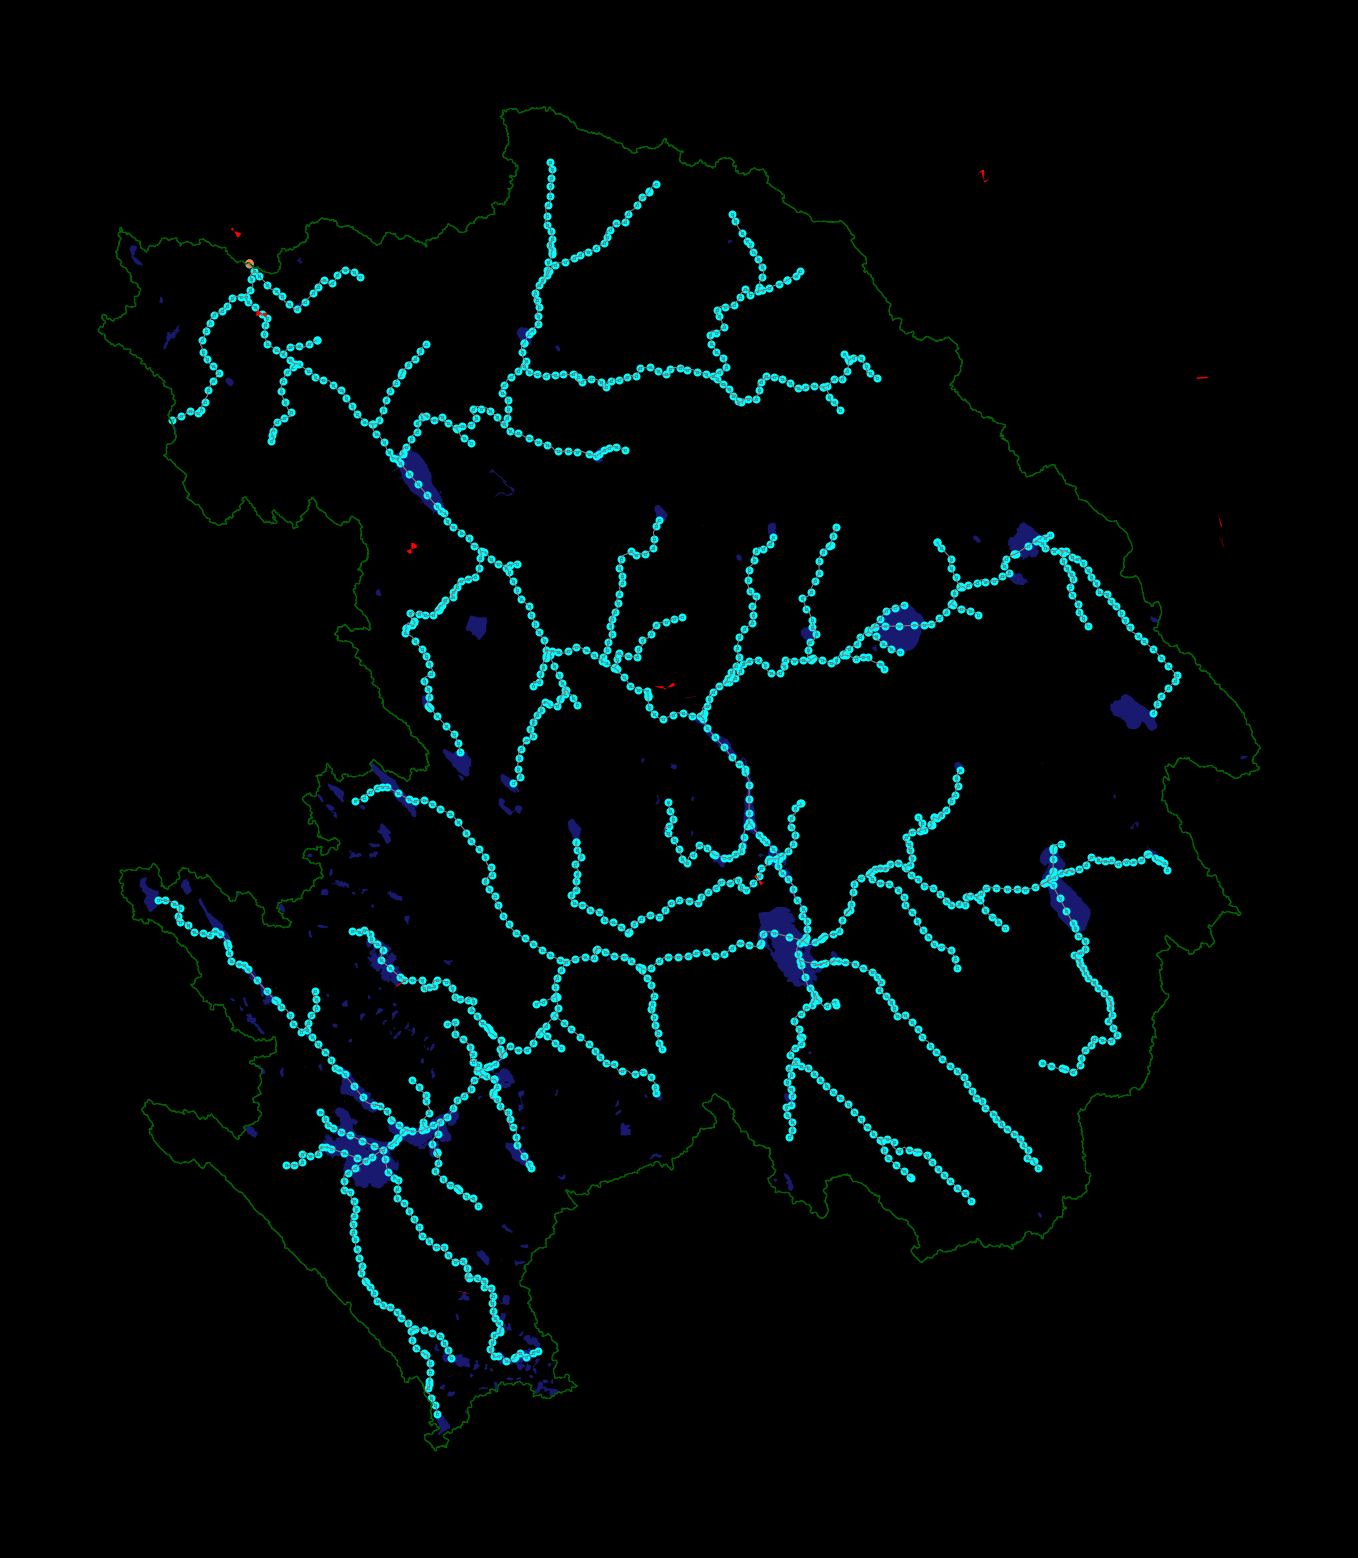

In [10]:
ax = watershed.boundary.plot(color='darkgreen', linewidth=0.2)
ax = lakes.plot(ax=ax, color='midnightblue')
#ax = boundary.plot(ax=ax, color='white', linewidth=0.1)
#ax = network.plot("tyyppi", cmap="cool", ax=ax, linewidth=0.2)
ax = network.plot(color='grey', ax=ax, linewidth=0.2)
#ax = test.plot(ax=ax, markersize=0.2, color='aqua')
#ax = orig_nodes.plot(ax=ax, markersize=0.2, color='aqua')
ax = nodes.plot(ax=ax, markersize=0.2, color='aqua')
#ax = problems.plot(ax=ax, markersize=0.2, color='red')
#ax = too_short.plot(ax=ax, markersize=0.2, color='lime')
#ax= orig_pour.plot(color='coral', ax=ax, markersize=0.3)
ax = pour.plot(color='coral', ax=ax, markersize=0.3)
#ax = suspects.plot(color='pink', ax=ax, markersize=0.6)
ax = dams.plot(ax=ax, color='red', linewidth=2)
#ax.set_xlim([network.total_bounds[0] -1000, network.total_bounds[2]-20000])
#ax.set_ylim([dams.total_bounds[1], dams.total_bounds[3]-23000])
plt.axis('off')

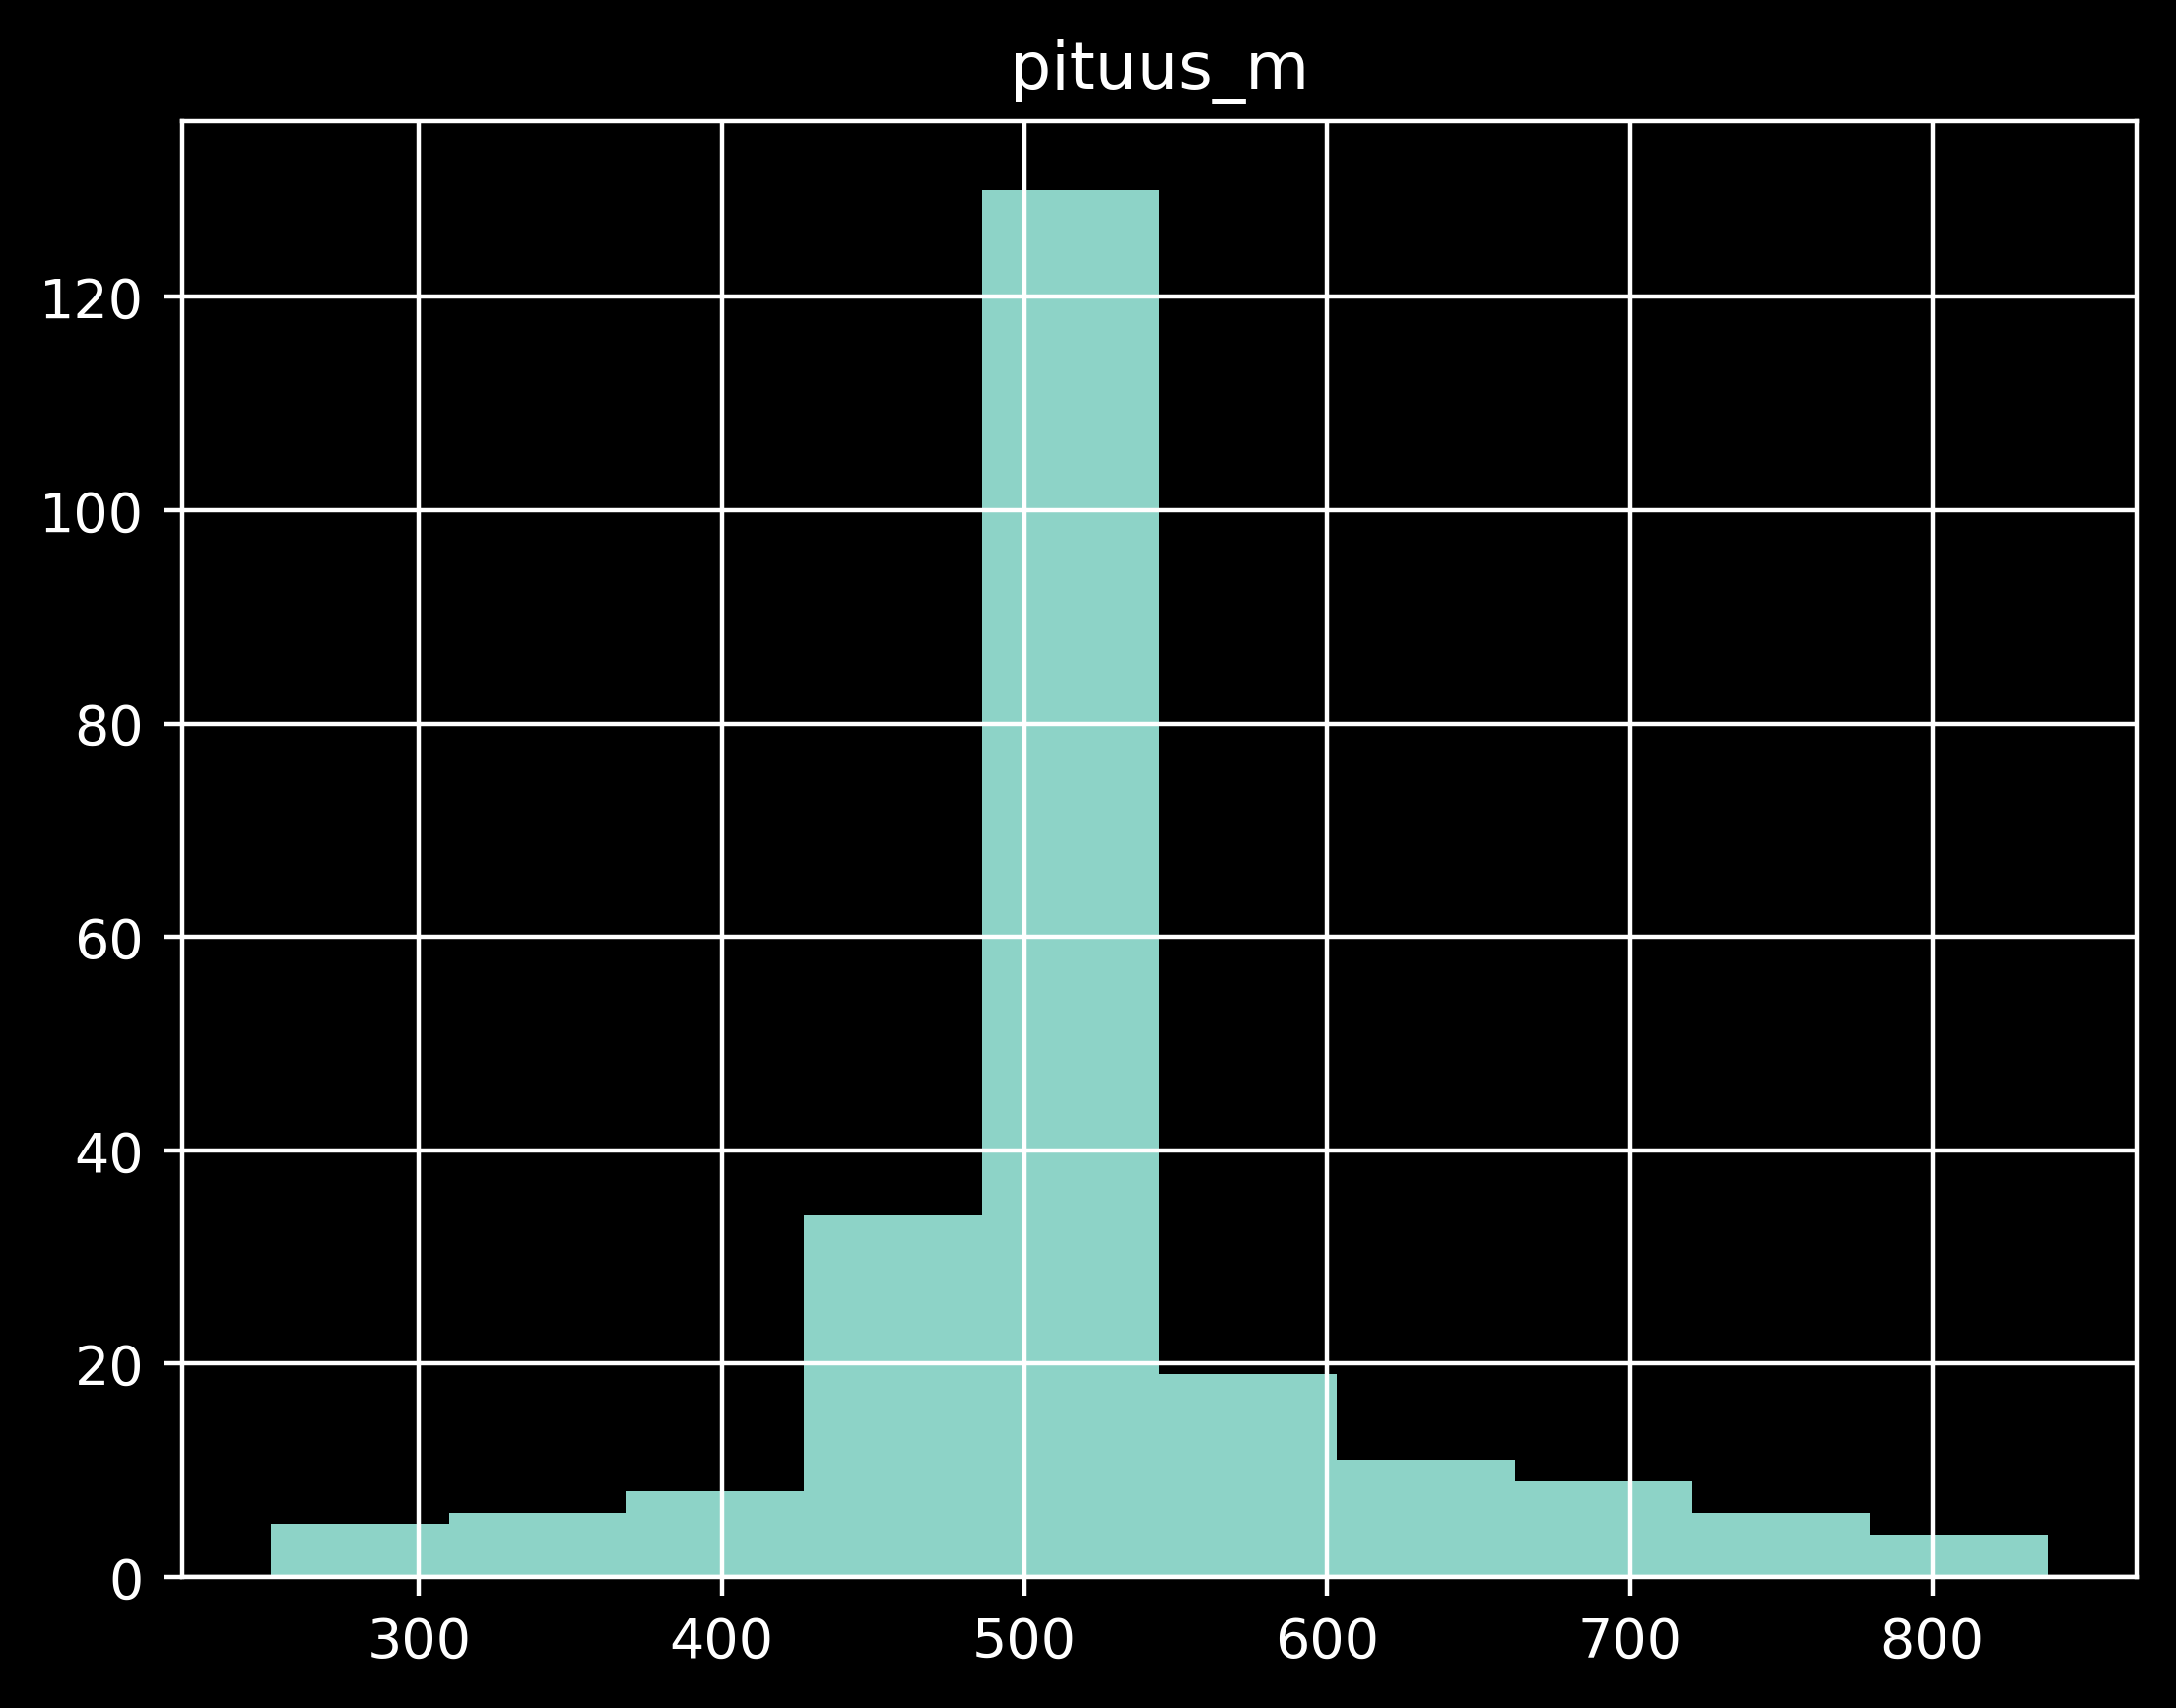

In [69]:
fig = test.hist("pituus_m")

In [23]:
 nodes.duplicated("geometry")

2      False
3      False
4      False
6       True
8      False
       ...  
782     True
784     True
786     True
788     True
790     True
Length: 396, dtype: bool

In [82]:
network

,tyyppi,Paikka_Id,main_basin_index,geometry,pituus_m
0,Allas,976,2.0,"LINESTRING (527183.062 6723031.648, 527183.078...",1.429598
1,Allas,976,2.0,"LINESTRING (527183.062 6723031.648, 527183.078...",1.429598
2,Allas,976,2.0,"LINESTRING (529959.128 6728335.956, 529959.921...",5.930210
3,Allas,976,2.0,"LINESTRING (529959.128 6728335.956, 529959.921...",5.930210
4,Allas,976,2.0,"LINESTRING (529486.696 6729350.696, 529538.802...",1137.561631
...,...,...,...,...,...
255,Uoma,NaN,NaN,"LINESTRING (523507.612 6747391.854, 523581.938...",128.809897
256,Uoma,NaN,NaN,"LINESTRING (523488.803 6748205.882, 523482.577...",1192.596205
257,Uoma,NaN,NaN,"LINESTRING (523488.803 6748205.882, 523482.577...",1192.596205
258,Uoma,NaN,NaN,"LINESTRING (522483.99 6751590.005, 522469.449 ...",5533.901634


In [96]:
network.pituus_m.min()

0.0001279059171516774

In [30]:
print(multiline)

MULTILINESTRING ((518705.278 6730386.037, 518712.427 6730381.973, 518715.795 6730380.059), (529964.635 6732536.898, 529973.129 6732530.211), (518728.005 6730373.118, 518733.485 6730370.003), (518702.436 6730387.652, 518705.278 6730386.037), (518715.795 6730380.059, 518728.005 6730373.118), (522133.286 6736070.162, 522122.523 6736080.904), (522976.731 6742589.458, 522987.048 6742596.944, 522989.321 6742606.291, 522989.485 6742623.034, 522989.185 6742630.96), (527509.659 6734406.696, 527508.616 6734434.007), (529056.06 6731634.429, 529067.615 6731647.592, 529074.234 6731666.405), (531905.787 6726576.467, 531916.262 6726581.05), (531916.262 6726581.05, 531944.66 6726593.476), (531944.66 6726593.476, 531952.686 6726596.987))


In [41]:
base_gdf=network.copy()

slicer = dams['geometry'].union_all()

sliced_segments = []

# Ensure both GeoDataFrames are in the same CRS
#if base_gdf.crs != cutter_gdf.crs:
    #cutter_gdf = cutter_gdf.to_crs(base_gdf.crs)

for line in base_gdf.geometry:
    #if not isinstance(line, LineString) or not isinstance(line, MultiLineString):
        #raise ValueError("All geometries in base_gdf must be LineStrings.")

    splitted = split(line, slicer)
    split_result = list(splitted.geoms)
            
    sliced_segments.extend(split_result)
    
sliced = geopd.GeoDataFrame({"geometry":sliced_segments}, geometry="geometry", crs=base_gdf.crs)
        

In [4]:
lines_1 = [LineString([(0, 0), (2,2)]), LineString([(0, 5), (5,5)])]
lines_2 = [LineString([(-1, 1), (3,1)])]

gdf_1 = geopd.GeoDataFrame({"geometry":lines_1}, crs="EPSG:3067", geometry="geometry")
gdf_2 = geopd.GeoDataFrame({"geometry":lines_2}, crs="EPSG:3067", geometry="geometry")

test_result = slice_linestrings(gdf_1, gdf_2)

In [146]:
print(LineString(dams.at[0, 'geometry']))

LINESTRING Z (598599.068 7002268.147 167.3, 598597.071 7002268.145 -999.999, 598595.632 7002267.575 168.348, 598594.769 7002266.415 167.3)


In [143]:
network.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
watershed

,Paikka_Id,main_basin_index,geometry
0,896,73,"MULTIPOLYGON (((663250 6908700, 663250 6908710..."


In [90]:
listing =[1]

if listing:
    print("Truthy")

Truthy


In [105]:
network

,tyyppi,Paikka_Id,main_basin_index,geometry,pituus_m
0,Allas,976,2.0,"LINESTRING (527183.062 6723031.648, 527183.37 ...",32.639680
1,Allas,976,2.0,"LINESTRING (527183.062 6723031.648, 527183.37 ...",32.639680
2,Allas,976,2.0,"LINESTRING (529959.128 6728335.956, 529962.605...",25.997659
3,Allas,976,2.0,"LINESTRING (529959.128 6728335.956, 529962.605...",25.997659
4,Allas,976,2.0,"LINESTRING (529473.527 6729365.811, 529474.623...",19.561450
...,...,...,...,...,...
583,Uoma,NaN,NaN,"LINESTRING (523924.91 6749537.864, 524011.302 ...",577.172756
584,Uoma,NaN,NaN,"LINESTRING (524477.757 6749530.623, 524488.759...",510.961061
585,Uoma,NaN,NaN,"LINESTRING (524626.575 6749156.908, 524625.786...",499.560099
586,Uoma,NaN,NaN,"LINESTRING (524518.707 6748689.492, 524517.549...",494.660729


In [42]:
sliced

,geometry
0,"LINESTRING (530381.366 6719846.218, 530391.073..."
1,"LINESTRING (530381.366 6719846.218, 530391.073..."
2,"LINESTRING (529076.944 6725185.158, 529080.307..."
3,"LINESTRING (529076.944 6725185.158, 529080.307..."
4,"LINESTRING (527183.062 6723031.648, 527183.37 ..."
...,...
107,"LINESTRING (523488.911 6748205.97, 523488.803 ..."
108,"LINESTRING (523879.774 6748268.27, 523820.022 ..."
109,"LINESTRING (523879.774 6748268.27, 523820.022 ..."
110,"LINESTRING (522483.99 6751590.005, 522469.449 ..."
